# Recreate Visualization in Matplotlib


Last week I watched an [interesting video](https://www.youtube.com/watch?v=RNdDyknuxaA) about recreating a D3.js chart using R ggplot.
This is the [original chart](https://bl.ocks.org/susielu/625aa4814098671290a8c6bb88a6301e) made using D3.js and this is the [recreated chart](https://github.com/aswansyahputra/reviz/blob/main/outfile/01-emmys.png) using ggplot.

In this post, I'll go through step by step to recreate the same chart, but using Matplotlib.

## Setup

Preparing libraries and utility functions.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import sys


from pprint import pprint


# plt.style.use("seaborn_v0_8")
plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.max_rows = 15

In [23]:
#########################
# some utility functions
#########################

class Head(object):
    
    def __init__(self, lines, fd=sys.stdout):
        self.lines = lines
        self.fd = fd
        
    def write(self, msg):
        if self.lines <= 0:
            return
        
        n = msg.count("\n")
        if n < self.lines:
            self.lines -= n
            return self.fd.write(msg)
        
        ix = 0
        while(self.lines > 0):
            iy = msg.find('\n', ix + 1)
            self.lines -= 1
            ix = iy
            
        return self.fd.write(msg[:ix])
    
    
def pprint_head(to_print, length=10):
    """
    Print first few lines of the text
    """
    pprint(to_print, stream=Head(length))
    
    
def glimpse(df, rows=10, info=False):
    """
    Display the first few rows (n) of the given dataframe
    If info=True, then display the result of dataframe.info() instead
    """
    if info:
        display(df.info())
    else:
        display(df.head(rows))
    return df

## Dataset

### Download the Raw Data

The raw data is in json format and can be downloaded from [here](https://gist.githubusercontent.com/susielu/625aa4814098671290a8c6bb88a6301e/raw/871576bf6cd336aee813ba97078b97fc91da3062/yearNetwork.json).

In [24]:
data_url = "https://gist.githubusercontent.com/susielu/625aa4814098671290a8c6bb88a6301e/raw/871576bf6cd336aee813ba97078b97fc91da3062/yearNetwork.json"
data_json = requests.get(data_url).json()
pprint_head(data_json, 10)  # only print first 10 lines

{'networkLines': [{'line': [{'value': 26, 'year': '2013'},
                            {'value': 26, 'year': '2014'},
                            {'value': 24, 'year': '2015'},
                            {'value': 24, 'year': '2016'},
                            {'value': 13, 'year': '2017'}],
                   'max': 26,
                   'network': 'AMC',
                   'total': 113},
                  {'line': [{'value': 32, 'year': '2013'},
                            {'value': 24, 'year': '2014'},

### Convert json into DataFrame

Once we get the json data, we will convert the data into a dataframe.
To do that, we use [`json_normalize`](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html?highlight=json_normalize#normalization) function in `pandas` that will normalize a json (or dict) into a flat dataframe.
At the end of the pipeline, we specify data type for each column to make sure that they have the correct data type.

**Tips**

Use `.pipe(glimpse, info=True)` to see data types for each column without leaving the current pipeline

In [25]:
df = (
    # convert json into tabular
    # ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html?highlight=json_normalize#normalization
    pd.json_normalize(data_json["networkLines"], "line", ["network", "total", "max"])
    # .pipe(glimpse, info=True)
    # specify data type for numeric variables
    .astype({"year": "int", "value": "int", "total": "int", "max": "int"})
)
df

,year,value,network,total,max
0,2013,26,AMC,113,26
1,2014,26,AMC,113,26
2,2015,24,AMC,113,26
3,2016,24,AMC,113,26
4,2017,13,AMC,113,26
...,...,...,...,...,...
54,2015,12,Amazon,44,16
55,2016,16,Amazon,44,16
56,2017,16,Amazon,44,16
57,2016,2,Hulu,20,18


### Pivot the Data into Wide Format

As we can see above, the dataframe is in long format.
That means, each row represents one observation and each column only represent 1 variable or metric.

For the next following steps, i.e. visualization, we need to pivot the dataframe into a wide format.
After pivoted, each row in the dataframe represents a single year and each column represents values for one network.


In [26]:
yearly_df = (
    df
    .copy()
    .pivot(index="year", columns="network", values="value")
    # remove column index name
    .rename_axis(None, axis=1)
)
yearly_df

,ABC,AMC,Amazon,CBS,FOX,FX Networks,HBO,Hulu,NBC,Nat Geo,Netflix,PBS,Showtime
year,,,,,,,,,,,,,
2013,45.0,26.0,NaN,54.0,20.0,26.0,109.0,NaN,53.0,NaN,14.0,25.0,32.0
2014,37.0,26.0,NaN,47.0,21.0,45.0,99.0,NaN,47.0,4.0,31.0,34.0,24.0
2015,42.0,24.0,12.0,41.0,36.0,39.0,126.0,NaN,43.0,4.0,34.0,30.0,18.0
2016,35.0,24.0,16.0,35.0,30.0,57.0,94.0,2.0,41.0,10.0,54.0,26.0,22.0
2017,33.0,13.0,16.0,29.0,20.0,55.0,111.0,18.0,64.0,15.0,91.0,11.0,15.0


Those `NaN` values in the dataframe above mean missing values.

## Visualization

### Basic Line Plot


First thing first, we will plot the basic line plot with year as the x-axis and network value as the y-axis.
There will be multiple lines and each line represent one network.

It is also useful to get the color map from the [orginal chart](https://bl.ocks.org/susielu/625aa4814098671290a8c6bb88a6301e), so that our chart will have similar color pallette.

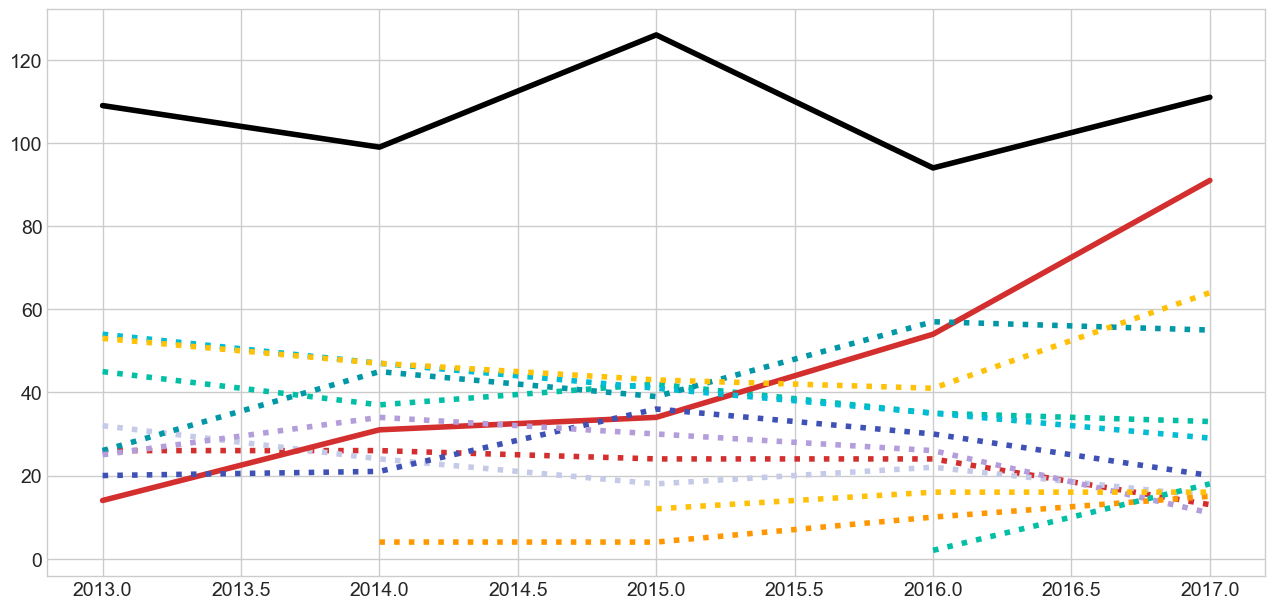

In [27]:
#| label: fig-line
#| fig-cap: Basic Line Plot

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot()

# colormap from the original chart
colormap = {
    "HBO": "black",
    "Netflix": "#D32F2F",
    "NBC": "#ffc107",
    "FX Networks": "#0097a7",
    "ABC": "#00BFA5",
    "CBS": "#00BCD4",
    "FOX": "#3f51b5",
    "Showtime": "#C5CAE9",
    "AMC": "#D32F2F",
    "PBS": "#B39DDB",
    "Amazon": "#ffc107",
    "Nat Geo": "#ff9800",
    "Hulu": "#00BFA5"
}

# iterate over unique networks
for n in df.network.unique():
    if n in ("HBO", "Netflix"):
        ax.plot(yearly_df.index, yearly_df[n], color=colormap[n], label=n)
    else:
        ax.plot(yearly_df.index, yearly_df[n], color=colormap[n], label=n, linestyle=":")


Note that we use two different line styles for the lines.
- Solid line for HBO and Netflix, and
- Dashed line for the other networks

Next, we will add the bullet points (scatter plot) on top of the lines

### Scatter Plot

We will only apply scatter plot only to Netflix and HBO networks

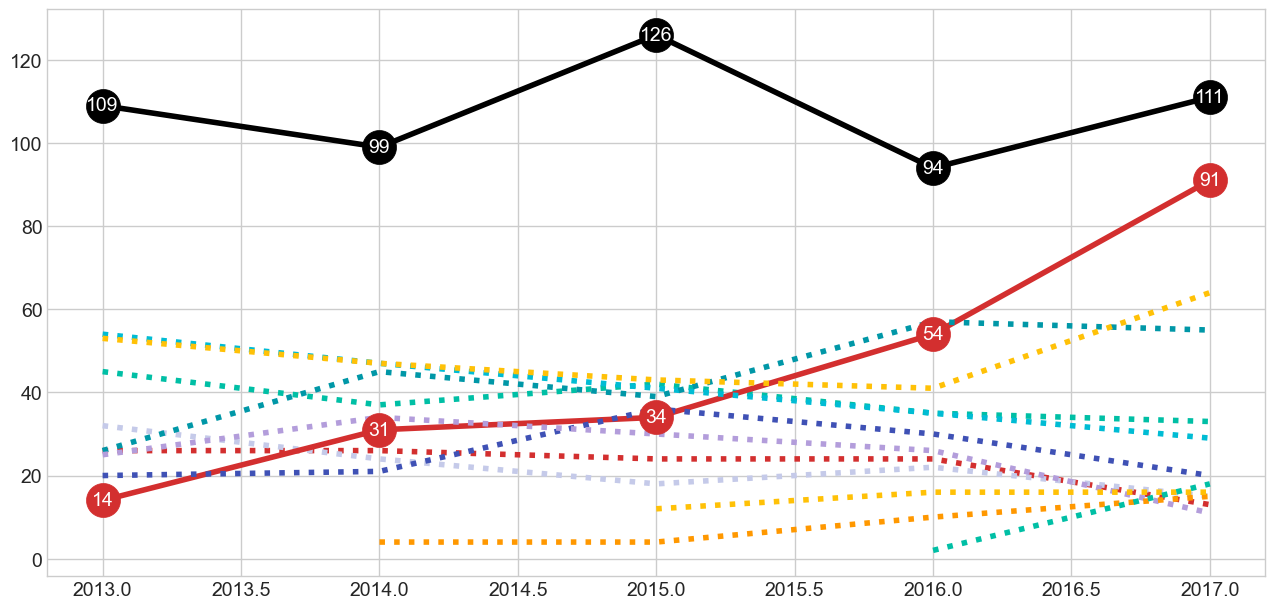

In [28]:
#| label: fig-scatter
#| fig-cap: Scatter Plot


# scatter point
# only Netflix and HBO that have points
ax.scatter(x=yearly_df.index, y=yearly_df.Netflix, s=600, zorder=3, color=colormap["Netflix"])
ax.scatter(x=yearly_df.index, y=yearly_df.HBO, s=600, zorder=3, color=colormap["HBO"])

# scatter label
for row in yearly_df.itertuples():
    ax.text(row.Index, row.Netflix, int(row.Netflix),
            ha="center", va="center",
            color="#fff",
            fontweight="normal", fontsize="medium")
    ax.text(row.Index, row.HBO, int(row.HBO),
            ha="center", va="center",
            color="#fff",
            fontweight="normal", fontsize="medium")
    
fig

It is important to make sure the labels are vertically (va) and horizontally (ha) centered.

### Legend


Next we are going to add legend text in the right-hand side of the chart.
To make sure that we have enough space to display the texts, we will set the x-axis value range from 2011 to 2018 (+1 year as an extra whitespace to be filled in by the text)

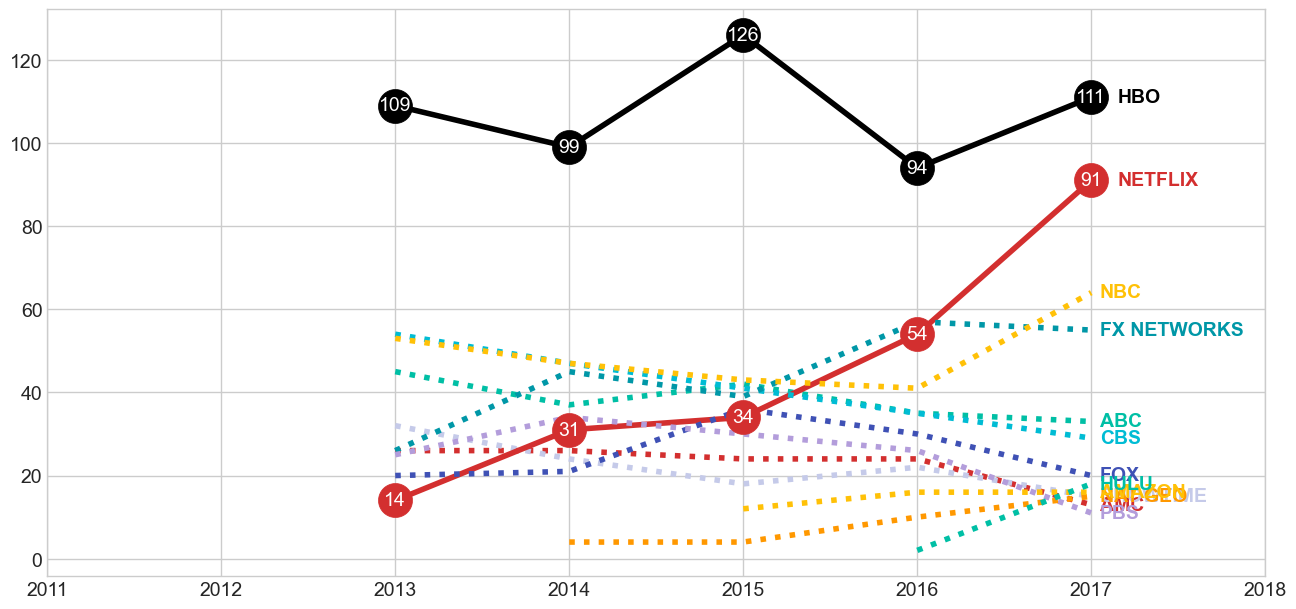

In [29]:
#| label: fig-legend
#| fig-cap: Add Legend


# legend
for n in df.network.unique():
    if n in ("HBO", "Netflix"):
        ax.text(2017.15, yearly_df.loc[2017, n], n.upper(),
                ha="left", va="center",
                color=colormap[n],
                fontweight="bold", fontsize="medium")
    else:
        ax.text(2017.05, yearly_df.loc[2017, n], n.upper(),
                ha="left", va="center",
                color=colormap[n],
                fontweight="bold", fontsize="medium")
        
# set x axis range
ax.set_xlim([2011, 2018])
fig

### Grid and Axis

Unlike any other standard charts, the chart has vertical grid lines and the x-axis ticks are written in the middle of the lines.
We are going to draw those grid lines and axis texts using `vlines` and `text`.

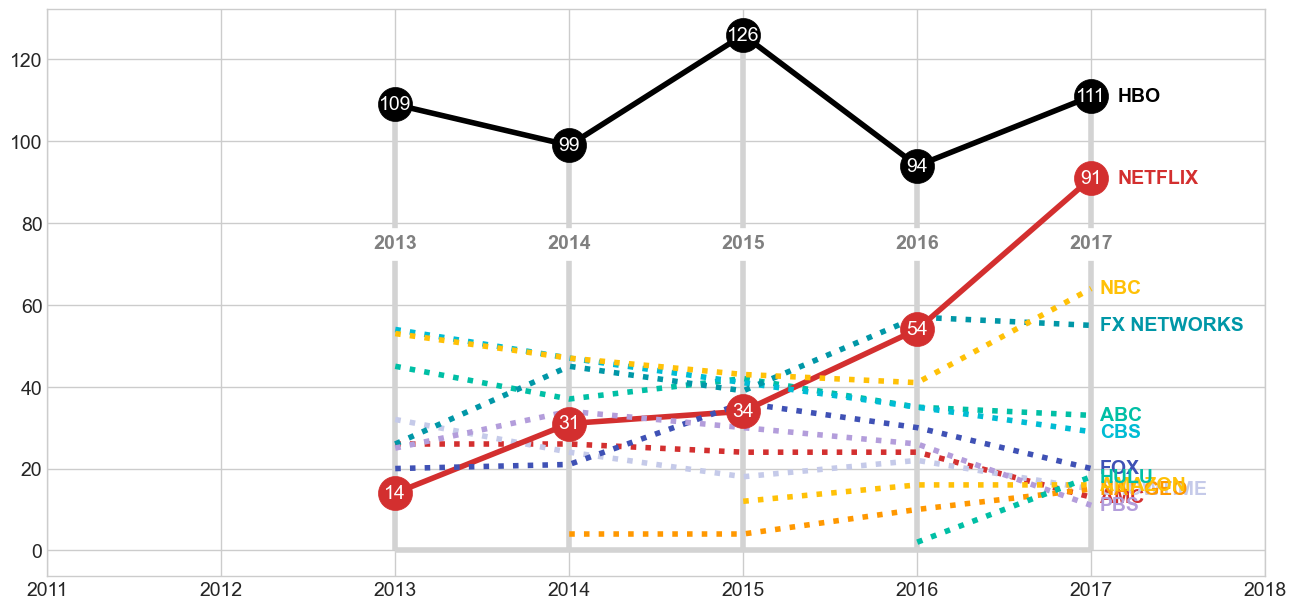

In [30]:
#| label: fig-grid
#| fig-cap: Grid and Axis


# horizontal bottom line
ax.hlines(xmin=yearly_df.index.min(), xmax=yearly_df.index.max(), y=0, color="lightgray", zorder=1)

# vertical lines
ax.vlines(yearly_df.index, ymin=0, ymax=yearly_df.HBO, color="lightgray", zorder=1)

# x-axis ticks
for row in yearly_df.itertuples():
    ax.text(row.Index, 75, row.Index,
            ha="center", va="center",
            backgroundcolor="#fff", color="gray",
            fontweight="bold",
            bbox={"pad": 5, "fc": "#fff", "ec": "#fff"})

fig

### Title

It is quite tricky to write the title since it has rich formatting (i.e. color, bold, and highlight).

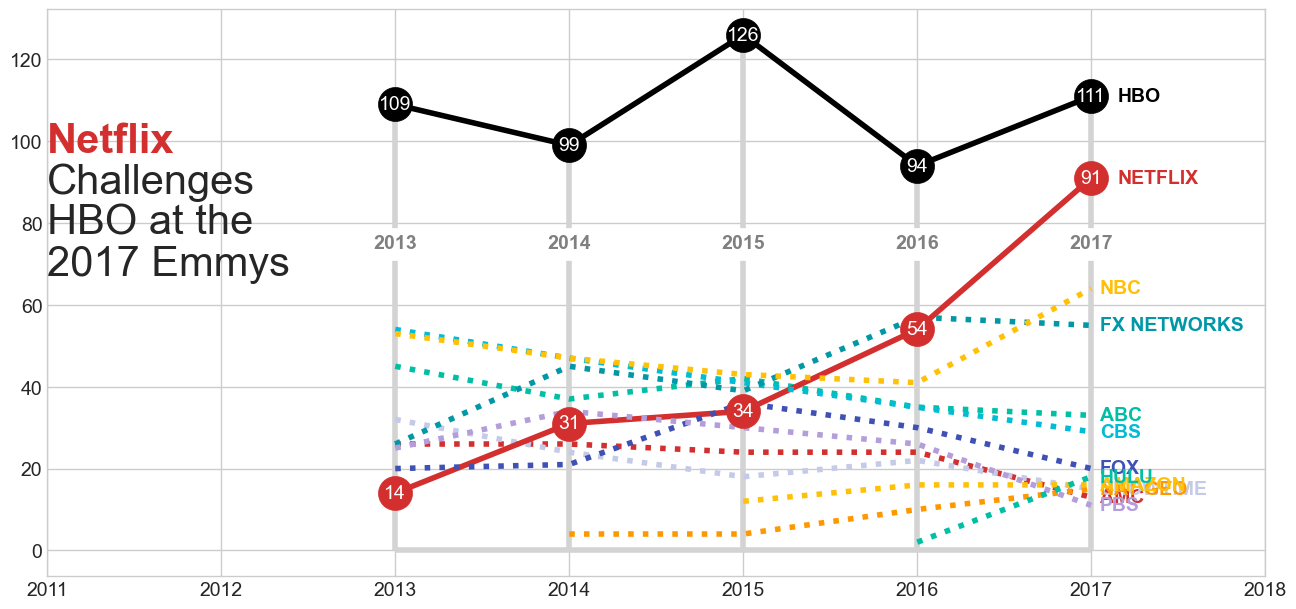

In [31]:
#| label: fig-title
#| fig-cap: Title


# title
ax.text(2011, 100, "Netflix",
        ha="left", va="center",
        color=colormap["Netflix"],
        fontweight="bold", fontsize=30)

ax.text(2011, 90, "Challenges",
        ha="left", va="center",
        fontweight="light", fontsize=30)

ax.text(2011, 80, "HBO at the",
        ha="left", va="center",
        fontweight="light", fontsize=30)

ax.text(2011, 70, "2017 Emmys",
        ha="left", va="center",
        fontweight="light", fontsize=30)

fig

### Final Version

In the final version, we combine all the parts above into a single block code.

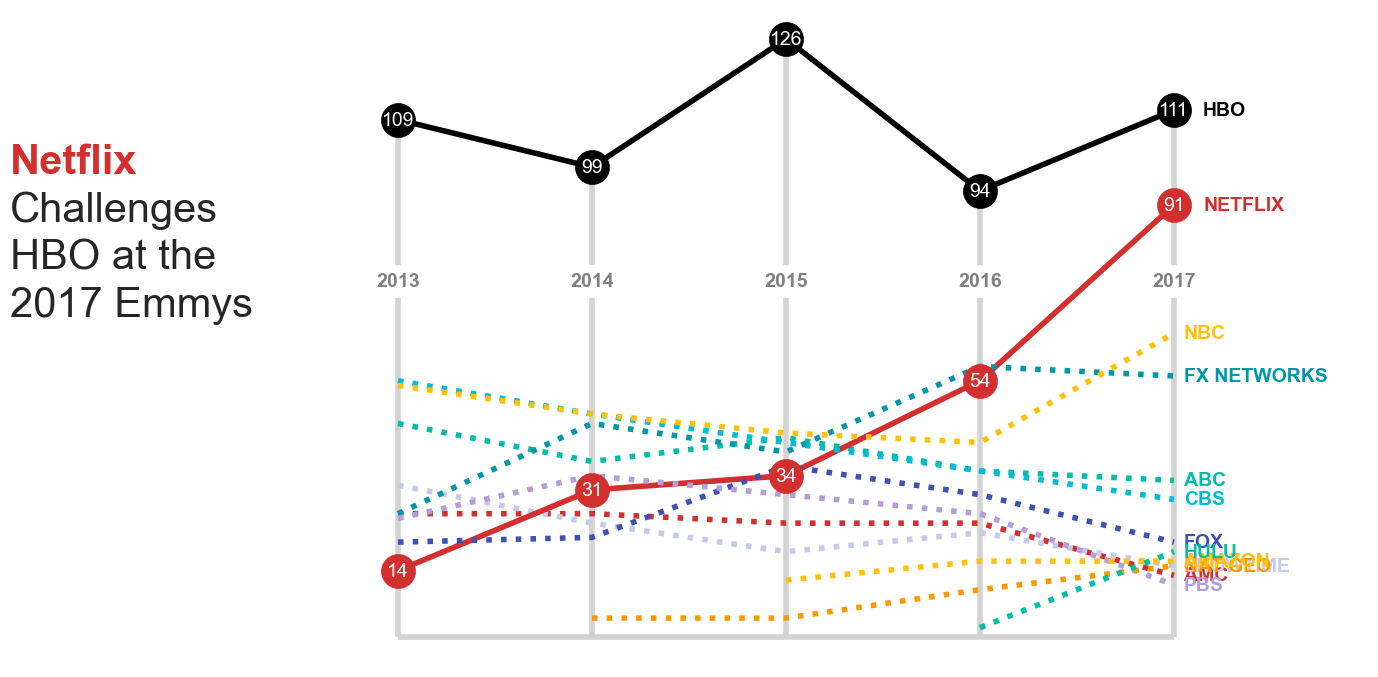

In [32]:
#| label: fig-final
#| fig-cap: Final Version


# colormap from the original chart
colormap = {
    "HBO": "black",
    "Netflix": "#D32F2F",
    "NBC": "#ffc107",
    "FX Networks": "#0097a7",
    "ABC": "#00BFA5",
    "CBS": "#00BCD4",
    "FOX": "#3f51b5",
    "Showtime": "#C5CAE9",
    "AMC": "#D32F2F",
    "PBS": "#B39DDB",
    "Amazon": "#ffc107",
    "Nat Geo": "#ff9800",
    "Hulu": "#00BFA5"
}

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot()

# horizontal bottom line
ax.hlines(xmin=yearly_df.index.min(), xmax=yearly_df.index.max(), y=0, color="lightgray", zorder=1)

# vertical lines
ax.vlines(yearly_df.index, ymin=0, ymax=yearly_df.HBO, color="lightgray", zorder=1)

# x-axis ticks
for row in yearly_df.itertuples():
    ax.text(row.Index, 75, row.Index,
            ha="center", va="center",
            backgroundcolor="#fff", color="gray",
            fontweight="bold",
            bbox={"pad": 5, "fc": "#fff", "ec": "#fff"})

# line plot
for n in df.network.unique():
    if n in ("HBO", "Netflix"):
        ax.plot(yearly_df.index, yearly_df[n], color=colormap[n], label=n)
    else:
        ax.plot(yearly_df.index, yearly_df[n], color=colormap[n], label=n, linestyle=":")

# scatter point
# only Netflix and HBO that have points
ax.scatter(x=yearly_df.index, y=yearly_df.Netflix, s=600, zorder=3, color=colormap["Netflix"])
ax.scatter(x=yearly_df.index, y=yearly_df.HBO, s=600, zorder=3, color=colormap["HBO"])

# scatter label
for row in yearly_df.itertuples():
    ax.text(row.Index, row.Netflix, int(row.Netflix),
            ha="center", va="center",
            color="#fff",
            fontweight="normal", fontsize="medium")
    ax.text(row.Index, row.HBO, int(row.HBO),
            ha="center", va="center",
            color="#fff",
            fontweight="normal", fontsize="medium")

# legend
for n in df.network.unique():
    if n in ("HBO", "Netflix"):
        ax.text(2017.15, yearly_df.loc[2017, n], n.upper(),
                ha="left", va="center",
                color=colormap[n],
                fontweight="bold", fontsize="medium")
    else:
        ax.text(2017.05, yearly_df.loc[2017, n], n.upper(),
                ha="left", va="center",
                color=colormap[n],
                fontweight="bold", fontsize="medium")
        
# title
ax.text(2011, 100, "Netflix",
        ha="left", va="center",
        color=colormap["Netflix"],
        fontweight="bold", fontsize=30)

ax.text(2011, 90, "Challenges",
        ha="left", va="center",
        fontweight="light", fontsize=30)

ax.text(2011, 80, "HBO at the",
        ha="left", va="center",
        fontweight="light", fontsize=30)

ax.text(2011, 70, "2017 Emmys",
        ha="left", va="center",
        fontweight="light", fontsize=30)

ax.set_xlim([2011, 2018])
ax.set_axis_off()
plt.tight_layout()
plt.show()


### Missing Parts

If you notice, the parts are reordered (e.g. grid lines are first) to make sure their layering stacks.
Elements on the upper layers (displayed later) shouldn't be occluded by any elements on the bottom layers.

The result above is already pretty much similar with the original visualization.
However, we still have some missing / uncovered parts:

1. Font family

    I use default font family.
    As consequences, the font look are not the same as in the original chart.
    
2. Rich title

    I found that it is not straight forward to write a rich texh format for chart title
    
3. Avoid text overlap

    As you might see on the legend texts (right-hand side) that the text are overlapped each other and unreadable.
    I haven't found solution for this issue.